## 数据字段说明
<br>

 | 变量名   | State  | Account Length | Area Code | Phone    | Int'l Plan       | VMail Plan 	   | VMail Message | Day Mins   | Day Calls    | Day Charge   | Eve Mins   | Eve Calls    | Eve Charge 	 | Night Mins | Night Calls  | Night Charge | Intl Mins  | Intl Calls   | Intl Charge  | CustServ Calls | Churn?         | 
 | ------   | ------ | ------         | ------    | ------   | ------           | ------           | ------        | ------     | ------       | ------       | ------     | ------       | ------       | ------     | ------       | ------       | ------     | ------       | ------       | ------         | ------         |
 | 变量解释 | 州     | 未知           | 区号      | 电话号码 | 是否为该计划用户 | 是否为该计划用户 | VMail消息量   | 每天通话量 | 白天通话次数 | 白天通话费用 | 傍晚通话量 | 傍晚通话次数 | 傍晚通话费用 | 夜间通话量 | 夜间通话次数 | 夜间通话费用 | 国际通话量 | 国际通话次数 | 国际通话费用 | 客服通话次数   | 是否为流失客户 | 

<br>
 数据很简单,每行代表一个预订的电话用户。 每列包含客户属性，例如电话号码，在一天中不同时间使用的通话分钟，服务产生的费用，生命周期帐户持续时间以及客户是否仍然是客户。

## 改进日志
- 0619,GDBT效果最好，未标准化
recall score:0.7609 

- 0620，基于卡方分布、最大信息系数选择特征，删了一个特征，训练集GDBT精确率提高0.5%，随机森林模型召回率提高了3%，精确率提高了0.5%
recall score:0.7609

- 0621,使用了好几种方式特征选择，有基于GDBT单变量特征选择、递归特征消除、基于L1正则化筛选特征、基于GDBT特征重要性特征选择，GDBT召回率提高了0.2%,最后对GDBT模型调参，召回率提高了1%
    <br>precision score: 0.8740
    <br>recall score:0.8043
- 0625,使用smote算法过采样，召回率提高了1.5%
    <br>precision score: 0.7740
    <br>recall score:0.8188

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [2]:
data=pd.read_csv("../input/churn.csv")
print data.shape
data.head()

(3333, 21)


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [3]:
# 查看特征列类型分布
data.dtypes.value_counts()

float64    8
int64      8
object     5
dtype: int64

In [4]:
# 查看具体哪些特征列是object类型
data.dtypes[data.dtypes=='object']

State         object
Phone         object
Int'l Plan    object
VMail Plan    object
Churn?        object
dtype: object

In [5]:
# 删除无关特征
# data=data.drop(['State','Phone'],axis=1)
data=data.drop(['State','Area Code','Phone'],axis=1)

In [6]:
# 类型转换
data['Churn?']=data['Churn?'].map(lambda x: 1 if x=='True.' else 0)
cols = ["Int'l Plan","VMail Plan"]
for col in cols:
    data[col]=data[col].map(lambda x: 1 if x=='yes' else 0)

In [7]:
# 检查缺失值
data.isnull().sum().sort_values()

Account Length    0
Intl Charge       0
Intl Calls        0
Intl Mins         0
Night Charge      0
Night Calls       0
Night Mins        0
Eve Charge        0
Eve Calls         0
Eve Mins          0
Day Charge        0
Day Calls         0
Day Mins          0
VMail Message     0
VMail Plan        0
Int'l Plan        0
CustServ Calls    0
Churn?            0
dtype: int64

In [8]:
#划分训练集和测试集
y=data.pop('Churn?')
train,test,train_y,test_y=train_test_split(data,y,test_size=0.3,random_state=0)

In [10]:
# 评价函数
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
def train_cv(X,y,clf):
    print("precision score: %.4f"%cross_val_score(clf, X, y, cv=cv, scoring='precision').mean())
    print("recall score:%.4f "%cross_val_score(clf, X, y, cv=cv,scoring='recall').mean())

In [10]:
train_cv(train,train_y,LR())
print
train_cv(train,train_y,SVC(random_state=0))
print
train_cv(train,train_y,KNN())
print
train_cv(train,train_y,RF(random_state=0))
print
train_cv(train,train_y,GBC(random_state=0))
print

precision score: 0.5336
recall score:0.1594 



C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision score: 0.0000
recall score:0.0000 

precision score: 0.6611
recall score:0.2957 

precision score: 0.8932
recall score:0.6261 

precision score: 0.9094
recall score:0.7362 



In [11]:
clf=GBC(random_state=0).fit(train,train_y)
pred=clf.predict(test)
metrics.recall_score(test_y,pred)

0.7608695652173914

### 方差筛选

In [12]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
selector.fit(train)
np.sort(selector.variances_)

array([8.43618159e-02, 2.01931364e-01, 5.73576300e-01, 1.74627960e+00,
       5.25428868e+00, 6.09123500e+00, 7.86880277e+00, 1.88390007e+01,
       8.53937717e+01, 1.86393707e+02, 3.92249779e+02, 4.02504989e+02,
       4.04660520e+02, 1.60401178e+03, 2.59458766e+03, 2.60742285e+03,
       2.95479183e+03])

In [13]:
for i in range(10,61,20):
    selector = VarianceThreshold(threshold=i/100)
    selector.fit(train)
    train1=selector.transform(train)

    train_cv(train1,train_y,GBC(random_state=0))
    print
    train_cv(train1,train_y,RF(random_state=0))
    print "____________________"

precision score: 0.9094
recall score:0.7362 

precision score: 0.8932
recall score:0.6261 
____________________
precision score: 0.9094
recall score:0.7362 

precision score: 0.8932
recall score:0.6261 
____________________
precision score: 0.9094
recall score:0.7362 

precision score: 0.8932
recall score:0.6261 
____________________


### 卡方检验

In [14]:
from sklearn.feature_selection import chi2
corrlation={}
for i in range(train.shape[1]):
    corrlation[train.columns[i]]=chi2(train,train_y)[0][i]
pd.DataFrame.from_dict(corrlation,orient='index').sort_values(by=[0],ascending=False)

,0
Day Mins,1705.004986
VMail Message,396.230247
Day Charge,289.853145
Eve Mins,180.204816
Int'l Plan,144.736938
CustServ Calls,141.636760
Night Mins,33.851782
Account Length,16.865716
VMail Plan,16.461508
Eve Charge,15.314133


In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
score=0
index=1
for i in range(1,train.shape[1]+1):
    model=SelectKBest(chi2,k=i)
    a_train=model.fit_transform(train,train_y)
    
    clf = GBC(random_state=0)
    cv_score=cross_val_score(clf, a_train, train_y, cv=cv, scoring='recall').mean()
    if score<cv_score:
        score=cv_score
        index=i
    print i,round(cross_val_score(clf, a_train, train_y, cv=cv, scoring='precision').mean(),4),round(cv_score,4)
print "______________________"
print index,score
# 被删除的特征
model=SelectKBest(chi2,k=index).fit(train,train_y)
train.columns[~model.get_support()]

1 0.5296 0.1594
2 0.6422 0.2377
3 0.6422 0.2377
4 0.7471 0.342
5 0.7314 0.3739
6 0.8123 0.6
7 0.8319 0.5913
8 0.8414 0.6
9 0.8389 0.6029
10 0.8447 0.6
11 0.8722 0.6696
12 0.9029 0.7478
13 0.8972 0.7478
14 0.8979 0.7478
15 0.9012 0.7478
16 0.9204 0.7536
17 0.9094 0.7362
______________________
16 0.7536231884057971


Index([u'Eve Calls'], dtype='object')

### 最大信息系数

In [16]:
from minepy import MINE
m=MINE()
cols=train.columns
corrlation={}
for col in cols:
    m.compute_score(train[col],train_y)
    corrlation[col]=m.mic()
pd.DataFrame.from_dict(corrlation,orient='index').sort_values(by=[0],ascending=False)

,0
Day Charge,0.164590
Day Mins,0.164590
Night Mins,0.086017
Eve Mins,0.085300
Eve Charge,0.081967
Night Charge,0.076459
CustServ Calls,0.060621
Intl Mins,0.051306
Intl Charge,0.051306
Account Length,0.046808


In [17]:
# 每次运行时出现的结果可能不同
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
score=0
index=1
for i in range(1,train.shape[1]+1):
    model=SelectKBest(mutual_info_classif,k=i)
    a_train=model.fit_transform(train,train_y)
    
    clf = GBC(random_state=0)
    cv_score=cross_val_score(clf, a_train, train_y, cv=cv, scoring='recall').mean()
    if score<cv_score:
        score=cv_score
        index=i
    print i,round(cross_val_score(clf, a_train, train_y, cv=cv, scoring='precision').mean(),4),round(cv_score,4)
print "______________________"
print index,score
# 被删除的特征
model=SelectKBest(mutual_info_classif,k=index).fit(train,train_y)
train.columns[~model.get_support()]

1 0.5255 0.1594
2 0.531 0.1623
3 0.6782 0.3652
4 0.6247 0.3855
5 0.7481 0.4783
6 0.7133 0.4812
7 0.6857 0.4696
8 0.7821 0.5362
9 0.7961 0.5565
10 0.8052 0.6174
11 0.8373 0.6232
12 0.8354 0.6261
13 0.8354 0.6261
14 0.8987 0.7507
15 0.9106 0.7362
16 0.8887 0.7478
17 0.9094 0.7362
______________________
14 0.7507246376811594


Index([u'Account Length', u'VMail Message', u'Eve Mins'], dtype='object')

### 基于相关系数的假设检验

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
score=0
index=1
for i in range(1,train.shape[1]+1):
    model=SelectKBest(f_classif,k=i)
    a_train=model.fit_transform(train,train_y)
    
    clf = GBC(random_state=0)
    cv_score=cross_val_score(clf, a_train, train_y, cv=cv, scoring='recall').mean()
    if score<cv_score:
        score=cv_score
        index=i
    print i,round(cross_val_score(clf, a_train, train_y, cv=cv, scoring='precision').mean(),4),round(cv_score,4)
print "______________________"
print index,score
model=SelectKBest(f_classif,k=index).fit(train,train_y)
train.columns[~model.get_support()]

1 0.0 0.0
2 0.6214 0.1681
3 0.623 0.3826
4 0.6247 0.3855
5 0.7059 0.4696
6 0.6998 0.4696
7 0.8133 0.5942
8 0.8105 0.5942
9 0.8478 0.6493
10 0.8478 0.6493
11 0.8822 0.7449
12 0.9003 0.7391
13 0.8973 0.7391
14 0.9032 0.7478
15 0.9012 0.7478
16 0.9204 0.7536
17 0.9094 0.7362
______________________
16 0.7536231884057971


Index([u'Eve Calls'], dtype='object')

### 基于GDBT的单变量特征选择

In [19]:
clf =GBC(random_state=0)
scores=[]
columns=train.columns
corrlation={}
for i in range(train.shape[1]):
    score=cross_val_score(clf,train.values[:,i:i+1],train_y.reshape(-1,1),scoring='recall',
                          cv=cv)
    corrlation[columns[i]]=format(np.mean(score),'.4f')
pd.DataFrame.from_dict(corrlation,orient='index').sort_values(by=[0],ascending=False)

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
CustServ Calls,0.1768
Day Charge,0.1594
Day Mins,0.1594
Eve Mins,0.0145
Eve Charge,0.0116
Night Mins,0.0087
Day Calls,0.0058
Night Charge,0.0058
Eve Calls,0.0029
Intl Calls,0.0029


In [20]:
# 删除特征重要性倒数第一的特征
train1=train.drop(['VMail Plan'],axis=1)
clf =GBC(random_state=0)
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

(0.9094, 0.7391)

### 递归特征消除

In [21]:
# 通过交叉验证自动确定消除特征数目
from sklearn.feature_selection import RFECV

clf=RFECV(estimator=GBC(random_state=0),step=1,cv=cv,scoring='recall')
clf.fit(train,train_y)
# 被消除的特征
print train.columns[~clf.support_],np.max(clf.grid_scores_)
# 消除特征剩余个数对应得分
#clf.grid_scores_

Index([u'Account Length', u'Night Calls'], dtype='object') 0.744927536231884


In [22]:
# 综合前面的选择，删除两个特征
train1=train.drop(['Night Calls','Account Length'],axis=1)
clf =GBC(random_state=0)
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

(0.8948, 0.7478)

### 基于L1的LR特征选择

In [23]:
# 每次运行结果不一样
from sklearn.feature_selection import SelectFromModel

score=0
index=0
clf1=LR(penalty="l1").fit(train.values, train_y.values.reshape(-1,1))
for i in range(60,160,5):
    model = SelectFromModel(clf1,threshold=i/100000.0)
    model.fit(train,train_y)
    train1=model.transform(train)
    clf =GBC(random_state=0)
    cv_score=cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean()
    if score<cv_score:
        score=cv_score
        index=i/100000.0
    print i/100000.0,cv_score
print
print index,score

0.0006 0.7362318840579711
0.00065 0.7362318840579711
0.0007 0.7362318840579711
0.00075 0.7362318840579711
0.0008 0.7362318840579711
0.00085 0.7362318840579711
0.0009 0.7362318840579711
0.00095 0.7362318840579711
0.001 0.7362318840579711
0.00105 0.7362318840579711
0.0011 0.744927536231884
0.00115 0.7507246376811595
0.0012 0.744927536231884
0.00125 0.7507246376811595
0.0013 0.7507246376811595
0.00135 0.7449275362318841
0.0014 0.7333333333333334
0.00145 0.7449275362318841
0.0015 0.7362318840579711
0.00155 0.7391304347826088

0.00115 0.7507246376811595


In [24]:
clf1=LR(penalty="l1").fit(train.values, train_y.values.reshape(-1,1))
model = SelectFromModel(clf1,threshold=index)
model.fit(train,train_y)
train1=model.transform(train)

clf =GBC(random_state=0)
print train.columns[~model.get_support()]
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

Index([u'Account Length', u'Night Calls', u'Night Charge', u'Intl Charge'], dtype='object')


(0.9047, 0.7507)

### 基于GDBT的特征选择

In [25]:
from sklearn.feature_selection import SelectFromModel

score=0
index=0
clf1=GBC(random_state=0).fit(train.values, train_y.values.reshape(-1,1))
for i in range(250,350,10):
    model = SelectFromModel(clf1,threshold=i/10000.0)
    model.fit(train,train_y)
    train1=model.transform(train)
    clf =GBC(random_state=0)
    cv_score=cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean()
    if score<cv_score:
        score=cv_score
        index=i/10000.0
    print i/10000.0,cv_score
print
print index,score

0.025 0.7391304347826088
0.026 0.7391304347826088
0.027 0.7391304347826088
0.028 0.744927536231884
0.029 0.7507246376811596
0.03 0.7507246376811596
0.031 0.7391304347826088
0.032 0.7391304347826088
0.033 0.7391304347826088
0.034 0.7391304347826088

0.029 0.7507246376811596


In [26]:
model = SelectFromModel(clf1,threshold=index)
model.fit(train,train_y)
train1=model.transform(train)

clf =GBC(random_state=0)
print train.columns[~model.get_support()]
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

Index([u'Account Length', u'VMail Plan', u'Day Calls', u'Eve Calls'], dtype='object')


(0.9069, 0.7507)

#### 小结
- 方差筛选
    - discarded feature: None
    - recall score:0.7362 
- 卡方检验
    - discarded feature: 'Eve Calls'
    - recall score:0.7536231884057971
- 互信息法
    - discarded feature: 'Account Length', 'VMail Message', 'Eve Mins'
    - recall score:0.7507246376811594
- 基于相关系数的假设检验
    - discarded feature: 'Eve Calls'
    - recall score:0.7536231884057971
- 基于GDBT的单变量特征选择
    - discarded feature: 'VMail Plan'
    - recall score:0.7391
- 递归特征消除
    - discarded feature: 'Night Calls','Account Length'
    - recall score:0.7478
- 基于L1的LR特征选择
    - discarded feature: 'Account Length', 'Night Calls', 'Night Charge', 'Intl Charge'
    - recall score:0.7507
- 基于GDBT的特征选择
    - discarded feature: 'Account Length', 'VMail Plan', 'Day Calls', 'Eve Calls'
    - recall score:0.7507

In [11]:
# 去除特征Eve Calls
train1=train.drop(['Eve Calls'],axis=1)
clf =GBC(random_state=0)
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

(0.9204, 0.7536)

In [38]:
# 去除特征Eve Calls,Night Calls
train1=train.drop(['Eve Calls', 'Night Calls'],axis=1)
clf =GBC(random_state=0)
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

(0.9046, 0.7536)

In [12]:
clf.fit(train1,train_y)
test1=test.drop('Eve Calls',axis=1)
pred=clf.predict(test1)
metrics.recall_score(test_y,pred),metrics.precision_score(test_y,pred)

(0.7753623188405797, 0.8492063492063492)

In [40]:
clf.fit(train1,train_y)
test1=test.drop(['Eve Calls','Night Calls'],axis=1)
pred=clf.predict(test1)
metrics.recall_score(test_y,pred)

0.7753623188405797

### GDBT调参

In [41]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(75,90,1)}
gsearch1 = GridSearchCV(estimator = GBC(learning_rate=0.1,max_depth=4,random_state=0), 
                   param_grid = param_test1, scoring='recall',iid=False,cv=cv)
gsearch1.fit(train1,train_y)
gsearch1.best_score_,gsearch1.best_params_

(0.7420289855072464, {'n_estimators': 78})

In [42]:
#调节参数max_depth和min_samples_split
param_test2 = {'max_depth':range(3,9,2), 'min_samples_split':range(2,503,100)}
gsearch2 = GridSearchCV(estimator =GBC(learning_rate=0.1, n_estimators=gsearch1.best_params_['n_estimators'],
                                                          random_state=0), 
                    param_grid = param_test2, scoring='recall',iid=False, cv=cv)
gsearch2.fit(train1,train_y)
gsearch2.best_score_,gsearch2.best_params_

(0.7565217391304347, {'max_depth': 5, 'min_samples_split': 2})

In [43]:
#调节参数min_samples_split和min_samples_leaf
param_test3 = {'min_samples_split':range(2,200,50), 'min_samples_leaf':range(1,100,10)}
gsearch3 = GridSearchCV(estimator = GBC(learning_rate=0.1, n_estimators=gsearch1.best_params_['n_estimators'],
                                                          max_depth=gsearch2.best_params_['max_depth'], random_state=0), 
                   param_grid = param_test3, scoring='recall',iid=False, cv=cv)
gsearch3.fit(train1,train_y)
gsearch3.best_score_,gsearch3.best_params_

(0.7623188405797101, {'min_samples_leaf': 1, 'min_samples_split': 52})

In [13]:
# clf = GBC(learning_rate=0.1, n_estimators=gsearch1.best_params_['n_estimators'],
#                             max_depth=gsearch2.best_params_['max_depth'], 
#                             min_samples_leaf =gsearch3.best_params_['min_samples_leaf'],
#                             min_samples_split =gsearch3.best_params_['min_samples_split'],
#                         random_state=0)
clf = GBC(learning_rate=0.1, n_estimators=78,
                            max_depth=5, 
                            min_samples_leaf =1,
                            min_samples_split =52,
                        random_state=0)
round(cross_val_score(clf, train1, train_y, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, train_y, cv=cv, scoring='recall').mean(),4)

(0.8711, 0.7565)

In [14]:
clf.fit(train1,train_y)
pred=clf.predict(test1)
metrics.recall_score(test_y,pred),metrics.precision_score(test_y,pred)

(0.8043478260869565, 0.8740157480314961)

#### smote算法过采样

In [16]:
# 过抽样处理库SMOTE
from imblearn.over_sampling import SMOTE 

# 建立SMOTE模型对象
model_smote = SMOTE() 
# 输入数据并作过抽样处理
x_smote_resampled, y_smote_resampled = model_smote.fit_sample(train,train_y) 
x_smote_resampled = pd.DataFrame(x_smote_resampled, columns=train.columns)
y_smote_resampled = pd.DataFrame(y_smote_resampled,columns=['Churn?']) 

In [17]:
# 去除特征Eve Calls
train1=x_smote_resampled.drop(['Eve Calls'],axis=1)
clf =GBC(random_state=0)
round(cross_val_score(clf, train1, y_smote_resampled, cv=cv, scoring='precision').mean(),4),round(cross_val_score(clf, train1, y_smote_resampled, cv=cv, scoring='recall').mean(),4)

C:\Users\starcor\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9659, 0.902)

In [18]:
clf = GBC(learning_rate=0.1, n_estimators=78,
                            max_depth=5, 
                            min_samples_leaf =1,
                            min_samples_split =52,
                        random_state=0)
clf.fit(train1,y_smote_resampled)
test1=test.drop(['Eve Calls'],axis=1)
pred=clf.predict(test1)
metrics.recall_score(test_y,pred),metrics.precision_score(test_y,pred)

(0.8188405797101449, 0.773972602739726)

####  异常值检测

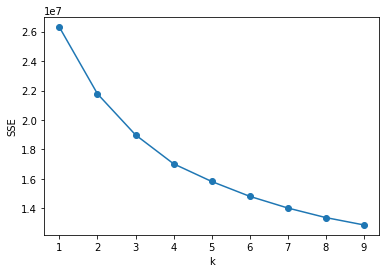

In [31]:
#聚类+手肘法
from sklearn.cluster import KMeans  
  
df = pd.concat([train,train_y],axis=1)
# 存放每次结果的误差平方和  
SSE = []  
for k in range(1,10):  
    estimator = KMeans(n_clusters=k)  # 构造聚类器  
    estimator.fit(df)  
    SSE.append(estimator.inertia_)  
X = range(1,10)  
plt.xlabel('k')  
plt.ylabel('SSE')  
plt.plot(X,SSE,'o-')  
plt.show()  

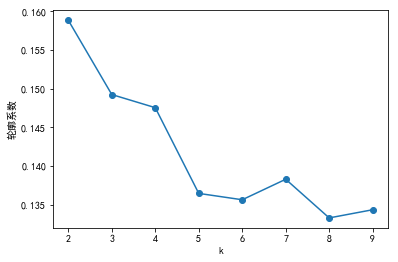

In [33]:
# 聚类+轮廓系数
from sklearn.metrics import silhouette_score
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# 存放轮廓系数  
Scores = []  
for k in range(2,10):  
    estimator = KMeans(n_clusters=k)  # 构造聚类器  
    estimator.fit(df)  
    Scores.append(silhouette_score(df,estimator.labels_,metric='euclidean'))  
X = range(2,10)  
plt.xlabel('k')  
plt.ylabel(u'轮廓系数')  
plt.plot(X,Scores,'o-')  
plt.show()  

In [81]:
df = pd.concat([train,train_y],axis=1).reset_index()

In [84]:
df=df.drop('index',axis=1)

In [86]:
df.shape

(2333, 18)

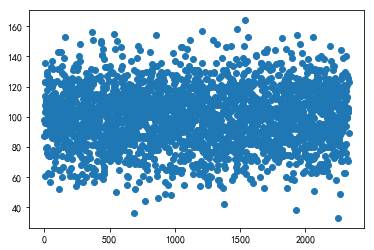

In [80]:
plt.scatter(df.index.values, df.loc[:,'Night Calls'].values, marker='o')
plt.show()

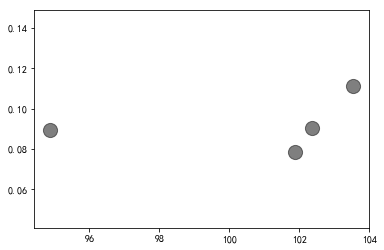

In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)